<div style="border: 2px solid #575757; padding: 10px; border-radius: 5px; background-color: #e1e1e1; color: black; text-align: center;">
  <h1 style="margin: 0;">Répartition des groupes thématiques</h1>
</div>

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Importation des librairies</h2>
</div>

**Ce bloc importe les bibliothèques nécessaires :**
- pandas pour manipuler les données tabulaires
- pulp pour la résolution du problème d’optimisation (programmation linéaire)
- random pour la génération aléatoire
- math pour les calculs liés à l’équilibre des genres
- tqdm pour afficher une barre de progression de l'algorithme quand nécessaire
- matplotlib et seaborn pour la génération de graphe

**On définit aussi les paramètres principaux :**
- 50 individus à répartir
- 5 groupes de 10 personnes chacun
- 3 genres possibles : H (homme), F (femme), N (neutre/non binaire)

In [1]:
# Librairies nécessaires
import pandas as pd
import numpy as np
import pulp
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Paramètres globaux
N_INDIVIDUS = 50
N_GROUPES = 5
TAILLE_GROUPE = 10
GENRES = ['H', 'F', 'NB']

<div style="border: 2px solid rgba(0, 158, 115, 1); padding: 10px; border-radius: 5px; background-color: rgba(0, 158, 115, 0.3); color: black; text-align: center;">
  <h2 style="margin: 0;">Génération aléatoire de groupes (pour test)</h2>
</div>

**On génère un example aléatoirement pour tester le notebook :**
- Chaque individu exprime 5 préférences
    - groupes classés de 1 à 5 sans doublon
    - colonnes indiquant l'ordre des préférences
    - nombre dans une cellule associé au n° du groupe
- Un genre aléatoire est assigné
- Les données sont sauvegardées dans un fichier CSV *preferences.csv*

In [3]:
# Générer les préférences et les genres aléatoirement
preferences = [random.sample(range(1, N_GROUPES + 1), 5) for _ in range(N_INDIVIDUS)]
genres = [random.choice(GENRES) for _ in range(N_INDIVIDUS)]

# Construction du DataFrame
headers = ["Préférence 1", "Préférence 2", "Préférence 3", "Préférence 4", "Préférence 5"]
df = pd.DataFrame(preferences, columns=headers)
df.insert(0, "Individu", [f"Individu {i+1}" for i in range(N_INDIVIDUS)])
df["Genre"] = genres

# Export CSV
df.to_csv("../data/preferences.csv", index=False)
df.head()

,Individu,Préférence 1,Préférence 2,Préférence 3,Préférence 4,Préférence 5,Genre
0,Individu 1,4,1,5,3,2,H
1,Individu 2,3,1,5,2,4,H
2,Individu 3,1,2,5,4,3,H
3,Individu 4,4,2,1,5,3,NB
4,Individu 5,1,2,3,4,5,NB


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Lecture du fichier et scores de préférence</h2>
</div>

**On lit les préférences depuis le CSV.**

**Chaque individu a un score de préférence (minimisation de sa dissatisfaction) pour chaque groupe :**
- 0 pour son 1er choix
- 1 pour le 2e, … jusqu’à 4
- Si un groupe n’est pas dans ses 5 choix, on lui attribue 5

**On trace une *heatmap* pour visualiser la répartition des préférences**

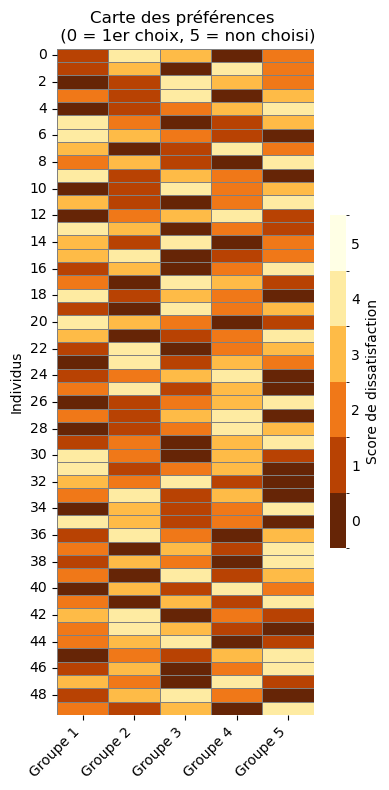

In [5]:
# Charger le fichier CSV (avec en-têtes)
df = pd.read_csv("../data/preferences.csv")

# Extraire les préférences (colonnes Groupe 1 à 5) et le genre
preferences = df.loc[:, ["Préférence 1", "Préférence 2", "Préférence 3", "Préférence 4", "Préférence 5"]].astype(int).values
genres = df["Genre"].values

# Générer les scores de préférence : 0 (1er choix), ..., 4 (5e choix), 5 si non choisi
score_pref = [[5] * N_GROUPES for _ in range(N_INDIVIDUS)] # Initialiser une matrice de score de taille (N_INDIVIDUS, N_GROUPES)
# Pour chaque individu i, lecture des préférences p pour groupes g
for i in range(N_INDIVIDUS):
    for p, g in enumerate(preferences[i]):
        score_pref[i][g - 1] = p  # g - 1 pour indexer les groupes de 0 à N-1

# score_pref[i][j] représente le niveau de dissatisfaction (0 à 5) que l'individu i aurait s’il était affecté au groupe j.

# Noms des groupes (index colonnes)
group_names = [f"Groupe {i+1}" for i in range(N_GROUPES)]

# Création d'un DataFrame (individus en lignes, groupes en colonnes)
df_scores = pd.DataFrame(score_pref, columns=group_names)

# Définir les bornes pour chaque valeur entière (de -0.5 à 5.5 pour couvrir 0 à 5)
bounds = [-0.5 + i for i in range(7)]  # [-0.5, 0.5, 1.5, ..., 5.5]

# Normalisation discrète pour les couleurs de la heatmap
norm = mcolors.BoundaryNorm(bounds, ncolors=256)

# Création de la heatmap
plt.figure(figsize=(4, 8))
ax = sns.heatmap(df_scores, cmap="YlOrBr_r", linewidths=0.5, linecolor='gray', norm=norm, 
                 cbar_kws={'ticks': range(6), 'label': 'Score de dissatisfaction', 'shrink': 0.5})

# Ajustement visuel de la colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(length=0)

# Ajustement visuel de la figure
plt.title("Carte des préférences \n (0 = 1er choix, 5 = non choisi)")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Individus")
plt.yticks(rotation=0)
plt.tight_layout()
# Décommenter la ligne suivante pour exporter le graphique en .png
# plt.savefig('Individuals_ScorePref.png', dpi=300, bbox_inches="tight")
plt.show()

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Résolution initiale</h2>
</div>

**On résout le problème d’affectation ainsi :**
- chaque individu est affecté à un seul groupe
- chaque groupe contient exactement 10 personnes
- on minimise la somme des scores de préférence (plus la somme est basse, plus les individus sont proches de leur 1er choix)

In [6]:
# On crée un problème linéaire nommé "Affectation"
# pulp.LpMinimize signifie que l’objectif sera de minimiser une fonction coût (ici la "satisfaction" globale inversée)
prob = pulp.LpProblem("Affectation", pulp.LpMinimize)

# x[i][j] est une variable binaire (0 ou 1) indiquant si l’individu i est affecté au groupe j
# La liste x est une matrice N_INDIVIDUS x N_GROUPES de variables
# Exemple : x[2][4] = 1 signifie que la personne 2 est dans le groupe 4
x = [[pulp.LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(N_GROUPES)] for i in range(N_INDIVIDUS)]

# Contrainte 1 : chaque personne dans un seul groupe
# Pour chaque individu i, la somme des variables binaires x[i][j] sur tous les groupes j doit être égale à 1
for i in range(N_INDIVIDUS):
    prob += pulp.lpSum(x[i]) == 1

# Contrainte 2 : 10 personnes par groupe
# Pour chaque groupe j, la somme des personnes affectées (x[i][j] pour tous les i) doit être égale à la taille fixe du groupe
for j in range(N_GROUPES):
    prob += pulp.lpSum(x[i][j] for i in range(N_INDIVIDUS)) == TAILLE_GROUPE

# Fonction objectif : minimiser le score total
# score_pref[i][j] est le "coût" ou "score de mécontentement" si la personne i est dans le groupe j 
# (0 = 1er choix, 1 = 2e, ..., 5 = non choisi).
prob += pulp.lpSum(x[i][j] * score_pref[i][j] for i in range(N_INDIVIDUS) for j in range(N_GROUPES))

# Résolution
solver = pulp.PULP_CBC_CMD(msg=0) # msg = 1 ou 0 selon qu'on veut l'affichage des messages ou non
prob.solve(solver)
optimal_value = pulp.value(prob.objective)

print("Valeur optimale trouvée :", optimal_value)

Valeur optimale trouvée : 4.0


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Génération des solutions optimales</h2>
</div>

**On génère toutes les solutions optimales différentes :**
- ayant le même score minimum
- en interdisant à chaque tour la dernière solution trouvée (pour éviter les doublons)

**Pour 50 personnes à répartir en 5 groupes de 10 :**
- Peut prendre longtemps (jusqu'à 1 h durant les tests) si toutes les combinaisons sont équivalentes
- Peut prendre 10 s à peine si le nombre de solutions optimales est faible
- Ne peut pas être anticipé à l'avance...

In [7]:
# Définir une limite dynamique de solutions à générer (commenter pour désactiver)
LIMIT_RATIO = 0.1  # 10% des permutations de préférences possibles
PREF_PERMS_PAR_PERSONNE = math.factorial(N_GROUPES)
print("Nombre de permutations de préférences par personne :", PREF_PERMS_PAR_PERSONNE)
MAX_SOLUTIONS = int(LIMIT_RATIO * PREF_PERMS_PAR_PERSONNE * N_INDIVIDUS)
print("Nombre maximum théorique de solutions à générer :", MAX_SOLUTIONS)
MAX_SOLUTIONS = min(MAX_SOLUTIONS, 1000)  # Borne de sécurité
print("Nombre maximum de solutions à générer après application de la borne de sécurité = 1000 :", MAX_SOLUTIONS)

# Initialisation de la liste de solutions
solutions = []

# Première solution archivée dans la liste
current_solution = [[int(pulp.value(x[i][j])) for j in range(N_GROUPES)] for i in range(N_INDIVIDUS)]
solutions.append(current_solution)

# Pour pouvoir comparer avec les solutions suivantes
# On stocke une string dans solution_set pour détecter rapidement les doublons
solution_set = {str(current_solution)}

# Affichage de progression dynamique
pbar = tqdm(total=None, desc="Recherche de solutions optimales 🔄")

# Recherche d'autres solutions
while True:
    # Interdire la dernière solution trouvée
    # Pour chaque variable binaire x[i][j], 
    # Si elle vaut actuellement 1, on prend (1 - x[i][j])
    # Sinon on prend x[i][j]
    constraint = pulp.lpSum([
        (1 - x[i][j] if current_solution[i][j] == 1 else x[i][j])
        for i in range(N_INDIVIDUS) for j in range(N_GROUPES)
    ])
    # La somme au moins égale à 1 implique qu'au moins une variable doit changer de valeur
    # Donc la solution sera différente
    prob += constraint >= 1

    # Relance la résolution, avec la contrainte d’exclusion
    prob.solve(solver)

    # On sort de la boucle si on ne trouve plus de nouvelle solution optimale
    if pulp.LpStatus[prob.status] != "Optimal" or pulp.value(prob.objective) != optimal_value:
        break

    # Si nouvelle solution
    current_solution = [[int(pulp.value(x[i][j])) for j in range(N_GROUPES)] for i in range(N_INDIVIDUS)]
    # On la stocke comme string
    sol_str = str(current_solution)
    # On la compare aux autres strings dans solution_set
    # Si unique, on l'ajoute
    if sol_str not in solution_set:
        solutions.append(current_solution)
        solution_set.add(sol_str)
        pbar.update(1) # update Affichage de progression

        # Affichage intermittent toutes les 100 solutions
        if len(solutions) % 100 == 0:
            print(f"{len(solutions)} solutions trouvées...")

        # Si critère de coupure activé et atteint, on sort
        if 'MAX_SOLUTIONS' in globals() and len(solutions) >= MAX_SOLUTIONS:
            print(f"⚠️ Arrêt anticipé après {MAX_SOLUTIONS} solutions.")
            break

pbar.close()
print(f"{len(solutions)} solutions optimales générées.")

Nombre de permutations de préférences par personne : 120
Nombre maximum théorique de solutions à générer : 600
Nombre maximum de solutions à générer après application de la borne de sécurité = 1000 : 600


Recherche de solutions optimales 🔄: 11it [00:00, 49.47it/s]

12 solutions optimales générées.


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Mesure du déséquilibre de genre pour chaque solution</h2>
</div>

**On évalue pour chaque solution :**
- son déséquilibre de genre dans chaque groupe
- via une mesure de variance
- moins il y a de variance, plus la répartition est équilibrée

In [8]:
# Initialisation de la liste d'équilibres genrés
balances = []

# On parcours toutes les solutions
for sol in solutions:
    
    # Valeur initiale à 0 (postulat d'équilibre)
    total_variance = 0
    
    # Pour chaque groupe j, liste des membres via indices des individus du groupe
    for j in range(N_GROUPES):
        membres = [i for i in range(N_INDIVIDUS) if sol[i][j] == 1]
        
        # Pour chaque membre i du groupe, genre récupéré via genres[i] et on incrémente counts
        counts = {"H": 0, "F": 0, "NB": 0}
        for i in membres:
            counts[genres[i]] += 1
        
        # Liste des effectifs par genre, ex. [4, 4, 2]
        valeurs = list(counts.values())
        moyenne = sum(valeurs) / len(valeurs)
        
        # Variance : éloignement de la moyenne
        variance = sum((v - moyenne)**2 for v in valeurs) / len(valeurs)
        
        # Écart-type : déséquilibre de la répartition genrée dans le groupe
        # On incrémente total_variance avec l'écart-type de chaque groupe
        # Donne le déséquilibre global de la solution parcourue
        total_variance += math.sqrt(variance)
    
    # Stockage du résultat
    balances.append(total_variance)

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Tirage au sort pondéré</h2>
</div>

**Un tirage au sort est effectué parmi toutes les solutions optimales**

**Les solutions mieux équilibrées en genre :**
- ont plus de chances d’être sélectionnées
- pondération via l'inverse de la variance

In [9]:
# Pondération inversement proportionnelle au déséquilibre de genre
# 1 + X pour éviter une division par 0
weights = [1 / (1 + b) for b in balances]

# Normalisation des poids pour obtenir des probabilités
somme = sum(weights)
probas = [w / somme for w in weights]

# Tirage aléatoire pondéré d'une unique solution
index = random.choices(range(len(solutions)), weights=probas, k=1)[0]
solution_choisie = solutions[index]

# On affiche le score de déséquilibre de la solution choisie
# Plus proche de 0 mieux c'est
print(f"Solution tirée au sort avec balance : {balances[index]:.2f}")

Solution tirée au sort avec balance : 6.94


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Répartition finale des groupes</h2>
</div>

**On affiche pour chaque groupe la liste des genres des personnes assignées**

In [10]:
for j in range(N_GROUPES):
    membres = [i for i in range(N_INDIVIDUS) if solution_choisie[i][j] == 1]
    genres_groupe = [genres[i] for i in membres]
    print(f"Groupe {j+1} ({len(membres)} personnes) : {genres_groupe}")

Groupe 1 (10 personnes) : ['H', 'NB', 'NB', 'H', 'H', 'F', 'F', 'H', 'H', 'H']
Groupe 2 (10 personnes) : ['F', 'NB', 'H', 'NB', 'NB', 'F', 'F', 'H', 'F', 'H']
Groupe 3 (10 personnes) : ['H', 'NB', 'NB', 'F', 'H', 'H', 'NB', 'NB', 'F', 'F']
Groupe 4 (10 personnes) : ['H', 'NB', 'NB', 'NB', 'NB', 'H', 'NB', 'H', 'F', 'NB']
Groupe 5 (10 personnes) : ['NB', 'H', 'NB', 'NB', 'NB', 'NB', 'F', 'F', 'F', 'NB']


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Exportation</h2>
</div>

**On sauvegarde la solution retenue dans un fichier CSV nommé *solution_choisie.csv***

In [11]:
df_sol = pd.DataFrame(solution_choisie)
df_sol.to_csv("../data/solution_choisie.csv", index=False, header=True)

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Visualisation équilibre de genre</h2>
</div>

**On génère un graphique à barres :**
- pour la solution tirée au sort
- illustre la composition de chaque groupe selon le genre (H/F/N)

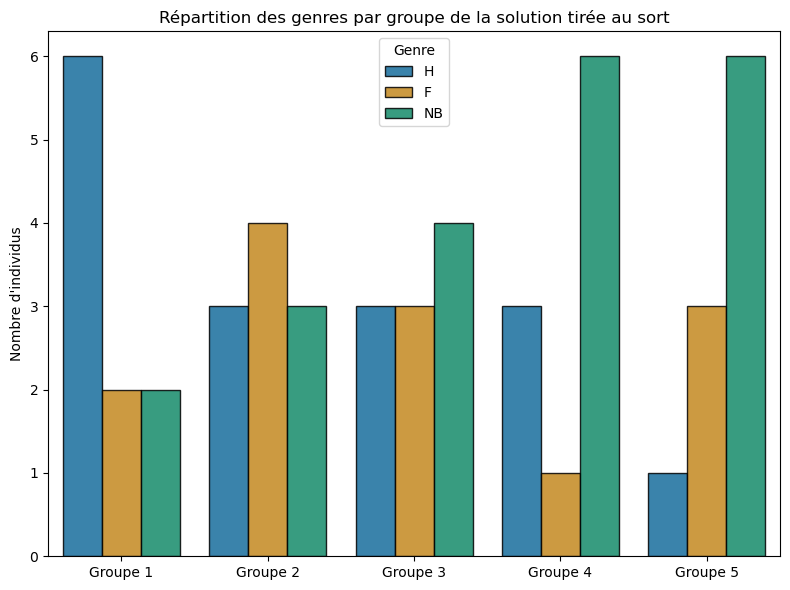

In [12]:
# Préparation des données pour seaborn
data_plot = []

for j in range(N_GROUPES):
    membres = [i for i in range(N_INDIVIDUS) if solution_choisie[i][j] == 1]
    counts = {"H": 0, "F": 0, "NB": 0}
    for i in membres:
        counts[genres[i]] += 1
    for genre, count in counts.items():
        data_plot.append({
            "Groupe": f"Groupe {j+1}",
            "Genre": genre,
            "Nombre": count
        })

df_plot = pd.DataFrame(data_plot)

# Affichage avec seaborn
plt.figure(figsize=(8, 6))
sns.set_palette("colorblind")

barplot = sns.barplot(
    data=df_plot,
    x="Groupe",
    y="Nombre",
    hue="Genre",
    edgecolor="black",
    alpha=0.85
)

plt.title("Répartition des genres par groupe de la solution tirée au sort")
plt.ylabel("Nombre d'individus")
plt.xlabel("")
plt.legend(title="Genre")
plt.tight_layout()
# Décommenter la ligne suivante pour exporter le graphique en .png
# plt.savefig('GroupRep_GenreEq.png', dpi=300, bbox_inches="tight")
plt.show()